In [1]:
from dockstring import load_target
import rdkit.Chem as Chem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import re
import sys
import time
import logging
import tempfile
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles, QED

import deepchem as dc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from scipy.sparse import csr_matrix, lil_matrix

#Then model is based on: (Karpathy/Ng-Video-Lecture, 2023)

In [102]:
from tensorflow import keras

#Create combined data

nrti = pd.read_csv('Data/nrtis_hiv_chemlb_full.csv')
prot = pd.read_csv('Data/hiv_protease_inhibitors_data_chemlb_full.csv')

df = pd.concat([nrti, prot], ignore_index=True)

#save to csv

df.to_csv('Data/bioactive_smiles.csv')

#df["canonical_smiles"] = df["canonical_smiles"].apply(lambda s: s.replace("\n", ""))


smiles = df['canonical_smiles']
#print(len(smiles))

text = str(smiles)

smiles.head()

0    COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N...
1    CCNc1cc(Oc2c(OC)cc3cc(C#N)ccc3c2OC)nc(Nc2ccc(C...
2    COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N2CCC(O)C2)nc(N...
3                      Cc1ccnc2c1NC(=O)c1cccnc1N2C1CC1
4      Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br
Name: canonical_smiles, dtype: object

In [103]:
def separate(s):
    stack = []
    sections = []
    for i, c in enumerate(s):
        if c in ['(', '[']:
            stack.append((c, i))
        elif c in [')', ']']:
            while stack:
                opening, start = stack[-1]  # Peek at the top of the stack
                if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                    stack.pop()  # Remove the matching opening bracket
                    sections.append((start, i))
                    break
                else:
                    stack.pop()  # Remove the non-matching opening bracket

    # Filter out overlapping sections
    non_overlapping_sections = []
    last_end = -1
    for start, end in sorted(sections, key=lambda x: x[0]):
        if start > last_end:
            non_overlapping_sections.append((start, end))
            last_end = end

    return non_overlapping_sections


def show_sections(s, sections):
    all_sections = []
    last_end = 0  # To keep track of the last section's end index

    for start, end in sections:
        if start > last_end:
            # Add the section between the last end and this start
            all_sections.append(s[last_end:start])
        # Add the section within the current parenthesis/bracket
        all_sections.append(s[start:end+1])
        last_end = end + 1  # Update the last end index

    # Handle any remaining section after the last parenthesis/bracket
    if last_end < len(s):
        all_sections.append(s[last_end:])

    return all_sections

s = smiles[0]
sections = separate(s)
all_sections = show_sections(s, sections)
" ".join(all_sections)

'COc1cc2cc (C#N) ccc2c (OC) c1Oc1cc (N) nc (Nc2ccc(C#N)cc2) n1'

In [52]:
text = ""

for i in tqdm(range(len(smiles))):
    sections = separate(smiles[i])
    all_sections = show_sections(s, sections)
    text += " ".join(all_sections)
    text += "*"

100%|██████████| 52/52 [00:00<00:00, 10782.81it/s]


In [53]:
print(text[:1000])

COc1cc2cc (C#N) ccc2c (OC) c1Oc1cc (N) nc (Nc2ccc(C#N)cc2) n1*COc1cc2 cc(C#N)ccc2c(OC)c1Oc1cc(N)nc (N c2ccc(C#N)cc2)n1*COc1cc2cc (C#N) ccc2c (OC) c1Oc1cc (N)nc(Nc2ccc (C #N)cc2)n1*COc1cc2cc(C# N)cc c2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1*COc1c c2cc( C# N)c cc2c(OC )c1Oc1cc(N)nc(Nc 2c cc( C#N)cc2)n1*COc1cc2cc( C#N) ccc 2c(OC )c1Oc1cc(N )nc(Nc2ccc (C#N)cc2)n1*COc1 cc2c c (C# N)cc c2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N) c c2) n1 *COc1 cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc (N c2ccc(C#N)cc2) n1 *CO c1c c2cc( C#N ) ccc2 c (OC )c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1*CO c1c c2 cc(C#N)ccc2c(OC)c1 Oc1cc (N)n c(Nc2c cc(C #N)cc2 )n1  *CO c1c c2 cc(C#N)ccc2c(OC)c1O c1cc( N)nc (Nc2cc c(C# N)cc2) n1  *CO c1c c2 cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1     *COc1 cc2 cc(C#N )ccc 2 c(OC)c 1Oc1cc(N)nc(N c 2ccc (C#N) cc2)n1        *CO c1c c2 cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1     *COc1cc2cc( C#N)c cc2c(OC)c1Oc1cc( N )nc( Nc2cc c(C#N) cc2) n 1     *COc 1cc 2cc (C#N )cc c2c( OC )c1 Oc1c c(N) nc(Nc2ccc(C#N)cc2)n1*

In [121]:
# Tokenize

chars = sorted(list(set(text)))
vocab_size = len(chars)


stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [94]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 500
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) 
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Unconstraint optimization of cross entropy loss function

In [122]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.207407 M parameters


In [123]:
un_loss_log = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    un_loss_log.append(loss.item())

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)

step 0: train loss 4.1399, val loss 4.1478
step 100: train loss 1.0383, val loss 0.9223
step 200: train loss 0.5097, val loss 0.3588
step 300: train loss 0.3828, val loss 0.2574
step 400: train loss 0.3714, val loss 0.2409
step 499: train loss 0.3393, val loss 0.2217


In [107]:
val = decode(m.generate(context, max_new_tokens=2000)[0].tolist())

In [124]:
new = "".join(val)
new = new.split('*')

new = [s for s in new if len(s) > 2]

new = [s.replace(' ', '') for s in new]
new

['COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(O(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(N)n1cc(Nc2ccc(C#N)cc2)n1',
 'COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(N)nc(C#Ncc2cc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(c(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc()n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)1Oc1cc(c(N)nc(Nc2cccc(C#N)cc2(OC)c1Oc1cc(N)nc(N)nc(Nc2ccc(CN)cc2n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)

[09:58:14] SMILES Parse Error: extra open parentheses for input: 'COc1cc2cc(C#N)ccc2c(O(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1'
[09:58:14] SMILES Parse Error: unclosed ring for input: 'COc1cc2cc(N)n1cc(Nc2ccc(C#N)cc2)n1'
[09:58:14] SMILES Parse Error: extra close parentheses while parsing: COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1
[09:58:14] SMILES Parse Error: Failed parsing SMILES 'COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1' for input: 'COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1'
[09:58:14] SMILES Parse Error: unclosed ring for input: 'COc1cc2cc(N)nc(C#Ncc2cc(C#N)cc2)n1'
[09:58:14] SMILES Parse Error: extra open parentheses for input: 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(c(N)nc(Nc2ccc(C#N)cc2)n1'
[09:58:14] SMILES Parse Error: syntax error while parsing: COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc()n1
[09:58:14] SMILES Parse Error: Failed parsing SMILES 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc()n1' for input: 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2

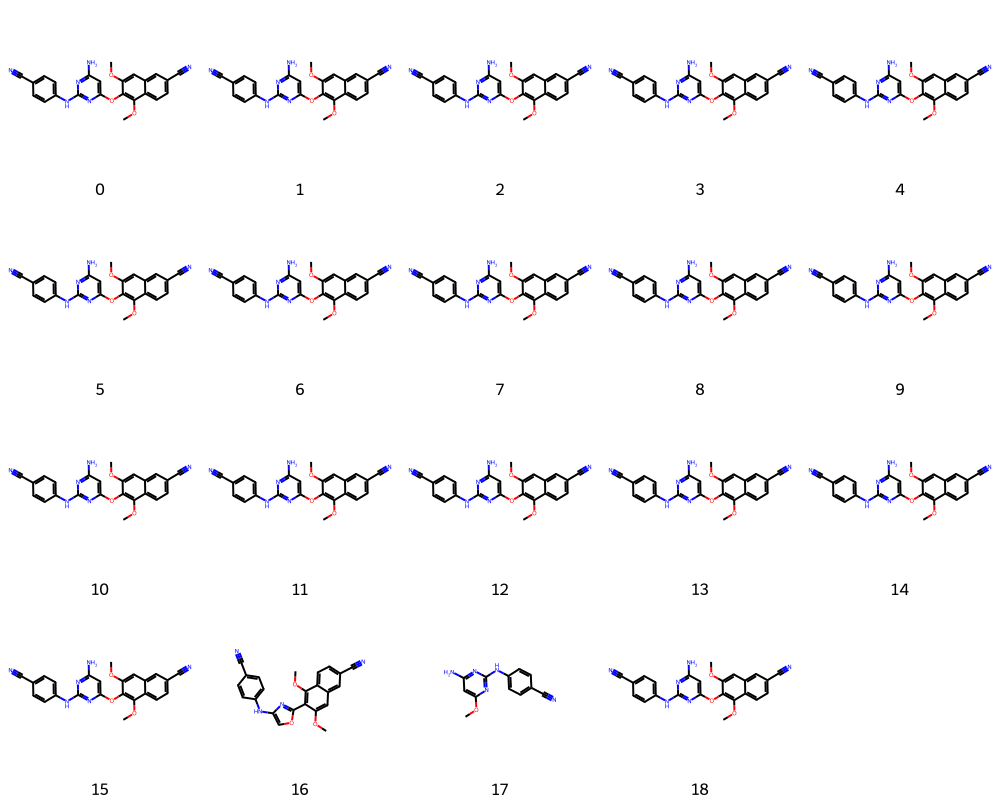

In [125]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


mols = [Chem.MolFromSmiles(smi) for smi in new if Chem.MolFromSmiles(smi) is not None]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in range(len(mols))])


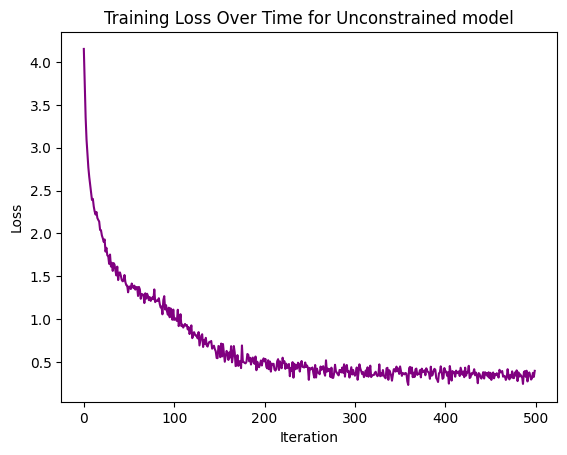

In [126]:
plt.plot(un_loss_log, color = 'purple')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for Unconstrained model')
plt.show()

# Modified model for use of constraint optimization

Constraint the losss function using penalty

In [111]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.202892 M parameters


In [112]:
def drug_likeness_penalty(smile):
    try:
        molecule = Chem.MolFromSmiles(smile)
        if molecule is None:
            return 0  # Return maximum penalty for invalid molecules
        qed_score = QED.qed(molecule)
        return qed_score
    except:
        # Handle any exception (including parse errors)
        return 0  # Return maximum penalty for errors
    

    

def custom_loss(base_loss, decoded_smiles, lambda_drug_likeness=0.1):
    drug_likeness_loss = 0
    valid_molecules = 0
    for smiles in decoded_smiles:
        if len(smiles) > 0:  # Check if SMILES string is not empty
            try:
                dl_penalty = 1 - drug_likeness_penalty(smiles)
                drug_likeness_loss += dl_penalty
                valid_molecules += 1
            except ValueError:
                continue

    # Averaging drug likeness loss over valid molecules in the batch
    if valid_molecules > 0:
        drug_likeness_loss /= valid_molecules

    total_loss = base_loss + lambda_drug_likeness * drug_likeness_loss
    return total_loss


In [113]:
cons_loss_log = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the base loss
    logits, base_loss = model(xb, yb)

    con_t = torch.zeros((1, 1), dtype=torch.long, device=device)
    decoded_smiles = decode(model.generate(con_t, max_new_tokens=100)[0].tolist())
    decoded_smiles = "".join(decoded_smiles)
    decoded_smiles = decoded_smiles.split('*')
    decoded_smiles = [s for s in decoded_smiles if len(s) > 2]
    decoded_smiles = [s.replace(' ', '') for s in decoded_smiles]

    costum_loss = custom_loss(base_loss, decoded_smiles, lambda_drug_likeness=0.1)
    
    optimizer.zero_grad(set_to_none=True)
    costum_loss.backward()
    optimizer.step()
    cons_loss_log.append(costum_loss.item())

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)


step 0: train loss 2.7438, val loss 2.7517


[09:27:18] SMILES Parse Error: syntax error while parsing: N#c#2(CnOc((NcOON##)n#c#NO2nCn
[09:27:18] SMILES Parse Error: Failed parsing SMILES 'N#c#2(CnOc((NcOON##)n#c#NO2nCn' for input: 'N#c#2(CnOc((NcOON##)n#c#NO2nCn'
[09:27:18] SMILES Parse Error: syntax error while parsing: 11(C2NC1nnNCOO1#1N1)OCc1c(#OCN1n2nOcO1((C(1#
[09:27:18] SMILES Parse Error: Failed parsing SMILES '11(C2NC1nnNCOO1#1N1)OCc1c(#OCN1n2nOcO1((C(1#' for input: '11(C2NC1nnNCOO1#1N1)OCc1c(#OCN1n2nOcO1((C(1#'
[09:27:18] SMILES Parse Error: extra close parentheses while parsing: O2c)1##1N(1CO21
[09:27:18] SMILES Parse Error: Failed parsing SMILES 'O2c)1##1N(1CO21' for input: 'O2c)1##1N(1CO21'
[09:27:18] SMILES Parse Error: syntax error while parsing: #C11
[09:27:18] SMILES Parse Error: Failed parsing SMILES '#C11' for input: '#C11'
[09:27:19] SMILES Parse Error: syntax error while parsing: Nccn(2C2cc(2nO(1(C
[09:27:19] SMILES Parse Error: Failed parsing SMILES 'Nccn(2C2cc(2nO(1(C' for input: 'Nccn(2C2cc(2nO(1(C'
[09:27

step 100: train loss 0.9228, val loss 0.7975


[09:29:16] SMILES Parse Error: syntax error while parsing: 1ccnc(N2cc2cc(C#N
[09:29:16] SMILES Parse Error: Failed parsing SMILES '1ccnc(N2cc2cc(C#N' for input: '1ccnc(N2cc2cc(C#N'
[09:29:16] SMILES Parse Error: extra close parentheses while parsing: C#Oc11Oc1c1ccc(N)c1c2cc2c2)nc2c(C)n1c1Occccc)c2
[09:29:16] SMILES Parse Error: Failed parsing SMILES 'C#Oc11Oc1c1ccc(N)c1c2cc2c2)nc2c(C)n1c1Occccc)c2' for input: 'C#Oc11Oc1c1ccc(N)c1c2cc2c2)nc2c(C)n1c1Occccc)c2'
[09:29:17] SMILES Parse Error: extra close parentheses while parsing: c2)n1Oc1Nccc2cc(C#Nc2n1c2cccn1n1ccc(COcc2cc2cc2cc(N)n1OC)n1c1Nc1cccccc2c(2c(N)
[09:29:17] SMILES Parse Error: Failed parsing SMILES 'c2)n1Oc1Nccc2cc(C#Nc2n1c2cccn1n1ccc(COcc2cc2cc2cc(N)n1OC)n1c1Nc1cccccc2c(2c(N)' for input: 'c2)n1Oc1Nccc2cc(C#Nc2n1c2cccn1n1ccc(COcc2cc2cc2cc(N)n1OC)n1c1Nc1cccccc2c(2c(N)'
[09:29:18] SMILES Parse Error: syntax error while parsing: COCOc1cc2cc1Oc(N)ncc(Nc2c(OC)ccc2c2cc2c(N)nc((C#N)n1(Occ2c(N(C#Nc1c2cc2ccc(C)cc(C)cc#N)n1O
[09:29:18] S

step 200: train loss 0.5180, val loss 0.3428


[09:31:17] SMILES Parse Error: extra close parentheses while parsing: COc1ccC#N)cc2cc(OC)c1Oc1cc2c2c()n1(C#Nc1ccc2c#N)n
[09:31:17] SMILES Parse Error: Failed parsing SMILES 'COc1ccC#N)cc2cc(OC)c1Oc1cc2c2c()n1(C#Nc1ccc2c#N)n' for input: 'COc1ccC#N)cc2cc(OC)c1Oc1cc2c2c()n1(C#Nc1ccc2c#N)n'
[09:31:17] SMILES Parse Error: extra close parentheses while parsing: COc1#N)ccc2((C#2c1OC)c1Oc1)n1ccc(N
[09:31:17] SMILES Parse Error: Failed parsing SMILES 'COc1#N)ccc2((C#2c1OC)c1Oc1)n1ccc(N' for input: 'COc1#N)ccc2((C#2c1OC)c1Oc1)n1ccc(N'
[09:31:18] SMILES Parse Error: extra close parentheses while parsing: Nc2ccc(C#N)cc2)n1
[09:31:18] SMILES Parse Error: Failed parsing SMILES 'Nc2ccc(C#N)cc2)n1' for input: 'Nc2ccc(C#N)cc2)n1'
[09:31:18] SMILES Parse Error: syntax error while parsing: CO1c1cc2cc2(C#N)ccc2(OC)c1Oc1ccc(N)nc(Nc2c(2cc(C#N)cc(OC)c1Oc1N)n1c
[09:31:18] SMILES Parse Error: Failed parsing SMILES 'CO1c1cc2cc2(C#N)ccc2(OC)c1Oc1ccc(N)nc(Nc2c(2cc(C#N)cc(OC)c1Oc1N)n1c' for input: 'CO1c1cc2cc2(C#N

step 300: train loss 0.3849, val loss 0.2648


[09:33:27] SMILES Parse Error: ring closure 1 duplicates bond between atom 2 and atom 3 for input: 'COc1c1cc2cc(C#N)ccc2Oc1cc(C#N)cc2c(OC)c(#N)ccn1Ncc2ccc(C#N)cc2cn11'
[09:33:27] SMILES Parse Error: syntax error while parsing: COc1cc2cc(
[09:33:27] SMILES Parse Error: Failed parsing SMILES 'COc1cc2cc(' for input: 'COc1cc2cc('
[09:33:29] SMILES Parse Error: unclosed ring for input: 'COc1cc2cc(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1'
[09:33:29] SMILES Parse Error: extra close parentheses while parsing: COc1ccc2c(c(C#N)ccOcN)c1)nc(Nnc(Nc2ccc
[09:33:29] SMILES Parse Error: Failed parsing SMILES 'COc1ccc2c(c(C#N)ccOcN)c1)nc(Nnc(Nc2ccc' for input: 'COc1ccc2c(c(C#N)ccOcN)c1)nc(Nnc(Nc2ccc'
[09:33:30] SMILES Parse Error: syntax error while parsing: COc1cc2cc(2c(C#N)cOc1cc(N)ncn1
[09:33:30] SMILES Parse Error: Failed parsing SMILES 'COc1cc2cc(2c(C#N)cOc1cc(N)ncn1' for input: 'COc1cc2cc(2c(C#N)cOc1cc(N)ncn1'
[09:33:30] SMILES Parse Error: unclosed ring for input: 'COc1'
[09:33:31] SMILES Parse Error: u

step 400: train loss 0.3620, val loss 0.2543


[09:35:30] SMILES Parse Error: syntax error while parsing: COc1ccc2c(c(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2cc(C#)cc2)n1
[09:35:30] SMILES Parse Error: Failed parsing SMILES 'COc1ccc2c(c(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2cc(C#)cc2)n1' for input: 'COc1ccc2c(c(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2cc(C#)cc2)n1'
[09:35:30] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(C#Oc1ccc(#N)cc2c(C'
[09:35:31] SMILES Parse Error: syntax error while parsing: )n1
[09:35:31] SMILES Parse Error: Failed parsing SMILES ')n1' for input: ')n1'
[09:35:31] SMILES Parse Error: extra close parentheses while parsing: COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)c2c(C)ccc(OCC#N))ccc1Oc2c1((OC)c1Oc1cc(N)c
[09:35:31] SMILES Parse Error: Failed parsing SMILES 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)c2c(C)ccc(OCC#N))ccc1Oc2c1((OC)c1Oc1cc(N)c' for input: 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)c2c(C)ccc(OCC#N))ccc1Oc2c1((OC)c1Oc1cc(N)c'
[09:35:33] SMILES Parse Error: syntax error while parsing: 2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1(
[0

step 499: train loss 0.3325, val loss 0.2088


[09:37:46] SMILES Parse Error: unclosed ring for input: 'COc1cc1c2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1'
[09:37:46] SMILES Parse Error: unclosed ring for input: 'COc1cc2cc(C#N)ccc2(OC)c1Occ1cc(N)'


In [117]:
c_val = decode(m.generate(context, max_new_tokens=2000)[0].tolist())

In [118]:
c_new = "".join(c_val)
c_new = c_new.split('*')

c_new = [s for s in new if len(s) > 2]

c_new = [s.replace(' ', '') for s in new]
c_new

['COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(O(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(N)n1cc(Nc2ccc(C#N)cc2)n1',
 'COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(N)nc(C#Ncc2cc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(c(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc()n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)ccc2c(OC)1Oc1cc(c(N)nc(Nc2cccc(C#N)cc2(OC)c1Oc1cc(N)nc(N)nc(Nc2ccc(CN)cc2n1',
 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1',
 'COc1cc2cc(C#N)

[09:51:06] SMILES Parse Error: extra open parentheses for input: 'COc1cc2cc(C#N)ccc2c(O(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1'
[09:51:06] SMILES Parse Error: unclosed ring for input: 'COc1cc2cc(N)n1cc(Nc2ccc(C#N)cc2)n1'
[09:51:06] SMILES Parse Error: extra close parentheses while parsing: COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1
[09:51:06] SMILES Parse Error: Failed parsing SMILES 'COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1' for input: 'COC)c1cc2ccc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc(C#N)cc2)n1'
[09:51:06] SMILES Parse Error: unclosed ring for input: 'COc1cc2cc(N)nc(C#Ncc2cc(C#N)cc2)n1'
[09:51:06] SMILES Parse Error: extra open parentheses for input: 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(c(N)nc(Nc2ccc(C#N)cc2)n1'
[09:51:06] SMILES Parse Error: syntax error while parsing: COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc()n1
[09:51:06] SMILES Parse Error: Failed parsing SMILES 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2ccc()n1' for input: 'COc1cc2cc(C#N)ccc2c(OC)c1Oc1cc(N)nc(Nc2

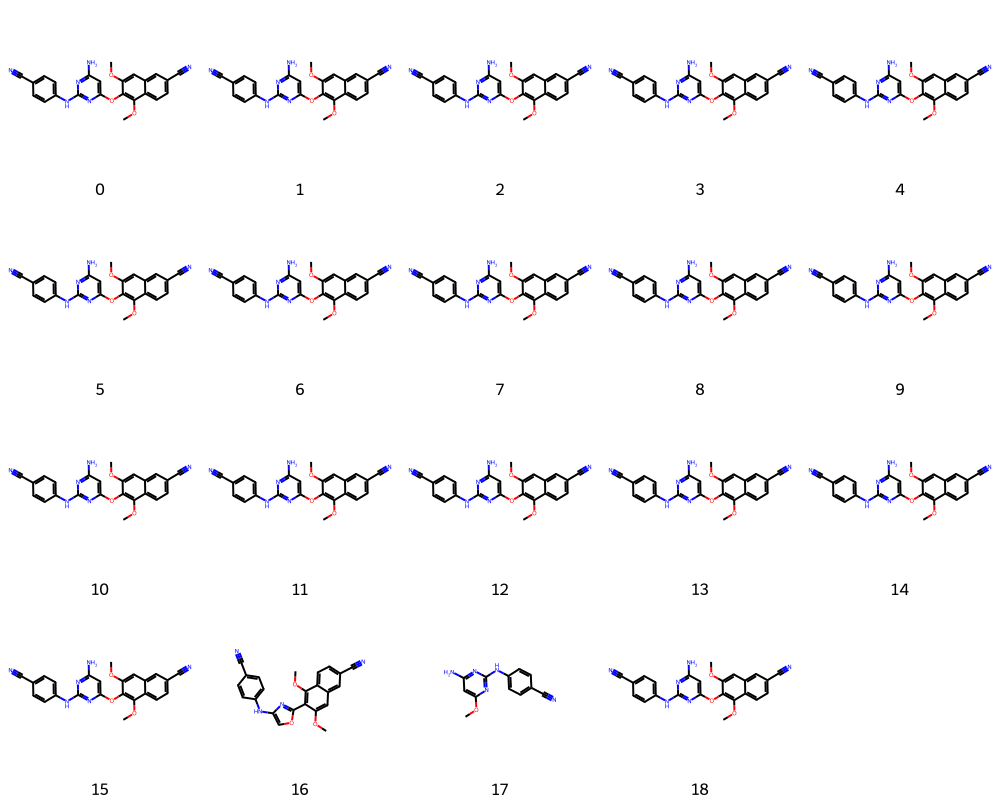

In [119]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


cmols = [Chem.MolFromSmiles(smi) for smi in c_new if Chem.MolFromSmiles(smi) is not None]
Draw.MolsToGridImage(cmols, molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in range(len(cmols))])

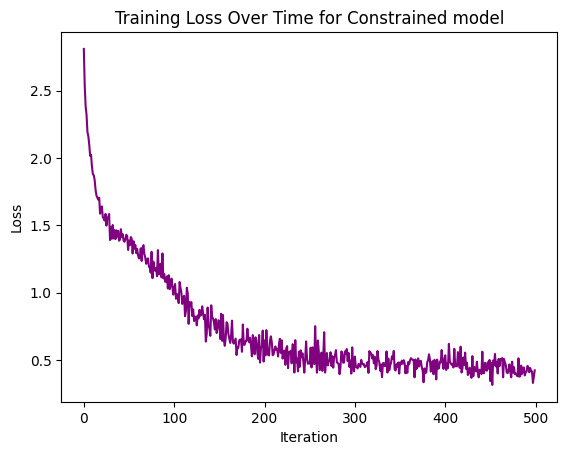

In [120]:
cons_loss_log

plt.plot(cons_loss_log, color = 'purple')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for Constrained model')
plt.show()

In [85]:
test = 'CC(=O)OC1=CC=CC=C1C(=O)O'
hi = Chem.MolFromSmiles(test)
QED.qed(hi)


0.5501217966938848